# Experiments for the paper

In [6]:
import jax, jax.numpy as jnp
import argparse
import matplotlib.pyplot as plt
import seaborn as sns
import os
from datetime import datetime
import math
jax.config.update('jax_platform_name', 'gpu')
jax.config.update('jax_enable_x64', False)

from src.stats.hmm import get_generative_model
from src.variational import get_variational_model
from src.training import SVITrainer
from src.stats.ula import ULA

def set_defaults(args):
    args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
    args.default_prior_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the prior
    args.default_transition_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the transition kernel
    args.default_transition_bias = 0.0
    args.default_emission_base_scale = 0.1
    args.parametrization = 'cov_chol'
    return args


def plot_x_true_against_x_pred(x_true, x_pred, y=None, save=False):
    dims = x_true.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(x_true[:,dim], c='red', label='True', alpha=0.7)
        axes[dim].plot(x_pred[:,dim], c='green', label='Pred', alpha=0.7)
        axes[dim].legend()
        if y is not None:
            axes[dim].plot(y[:,dim], c='black', label='Obs', alpha=0.5)
    if save: plt.savefig('test.pdf', format='pdf')


def plot_data(y):
    dims = y.shape[-1]
    _ , axes = plt.subplots(dims, 1, figsize=(15,2*dims))
    for dim in range(dims):
        axes[dim].plot(y[:,dim], label='Data')

def compute_rmse_x_true_against_x_pred(x_true, x_pred):
    rmse = jax.vmap(lambda x,y: jnp.mean(jnp.sqrt(jnp.mean((x-y)**2, axis=-1)), axis=0))
    print('RMSE:',rmse.tolist())


## Linear-Gaussian HMM 

### Setting up data and generative model

In [27]:
key = jax.random.PRNGKey(0) # seed
p_args = argparse.Namespace() # will contain all configuration information for the generative model 
p_args.state_dim, p_args.obs_dim = 2,2 # dimensions of state and observation spaces
p_args.model = 'linear'
p_args.seq_length = 500
p_args.emission_bias = False # no bias in the emission kernel, i.e. only Y_t = B X_t + noise
p_args.transition_bias = False # no bias in the transition kernel, i.e. only X_t = A X_{t-1} + noise
p_args.transition_matrix_conditionning = 'diagonal' # the transition matrix will be diagonal
p_args.range_transition_map_params = [0.9,1] # the diagonal values are constrained to [0.9 1]
p_args.num_seqs = 1 #
p_args = set_defaults(p_args) # setting default values for the covariances with realistic Signal to noise ratios

key, key_theta, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_theta) # getting the model and its parameters 
# save_args(p_args, 'args', exp_path) # saving the params of the generative model
# save_params(theta, 'theta', exp_path) # saving the parameters
# jnp.save(os.path.join(exp_path, 'xs'), xs)
# jnp.save(os.path.join(exp_path, 'ys'), ys)

In [28]:
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     p_args.num_seqs, 
                                     p_args.seq_length,
                                     single_split_seq=False, # not sampling a sequence and splitting into subsequences
                                     load_from='', # not loading from external folder
                                     loaded_seq=False) # not loading sequences

### Setting up variational model and training parameters

In [29]:
q_args = argparse.Namespace() # will contain all configuration information for the variational model 
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'linear' 
q_args.emission_bias = False 
q_args.transition_bias = False 
q_args.transition_matrix_conditionning = 'diagonal' 
q_args.range_transition_map_params = [0.9,1] 
q_args = set_defaults(q_args) 
# sub_exp_path = os.path.join(exp_path, q_args.model)
# os.makedirs(sub_exp_path, exist_ok=True)
# save_args(p_args, 'args', sub_exp_path) # saving the params of the generative model
q = get_variational_model(q_args) # getting the corresponding model


### Learning in an offline setting

Num params: 14
Monitor ELBO is analytical.
USING ANALYTICAL ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:01<00:00, 853.45it/s]


Num params: 14
Monitor ELBO is analytical.
USING AUTODIFF ON BACKWARD BATCH ELBO.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:01<00:00, 604.89it/s]


Num params: 14
Monitor ELBO is analytical.
USING SCORE ELBO.
Using full gradients.


Running for 1,000 iterations: 100%|██████████| 1000/1000 [00:04<00:00, 238.48it/s]


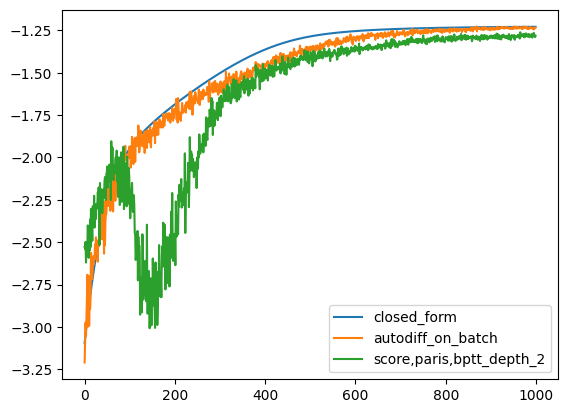

In [10]:
key = jax.random.PRNGKey(1)
for elbo_mode in ['closed_form', 'autodiff_on_batch', 'score,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-3, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1000, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode=f'reset,{p_args.seq_length},1', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=q_args, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()

HMM.Params(prior={'_mean': Array([-0.02367444,  0.03465972], dtype=float64), '_scale': {'cov_chol': Array([0.34264781, 0.28712101], dtype=float64)}}, transition=KernelParams(map={'w': Array([1.23952967, 0.69617992], dtype=float64)}, noise=Gaussian.NoiseParams(scale={'cov_chol': Array([0.37810489, 0.28825937], dtype=float64)})), emission=KernelParams(map={'w': Array([[0.57873462, 0.63125761],
       [0.84143863, 0.20983095]], dtype=float64)}, noise=Gaussian.NoiseParams(scale={'cov_chol': Array([0.28723231, 0.28061335], dtype=float64)})))


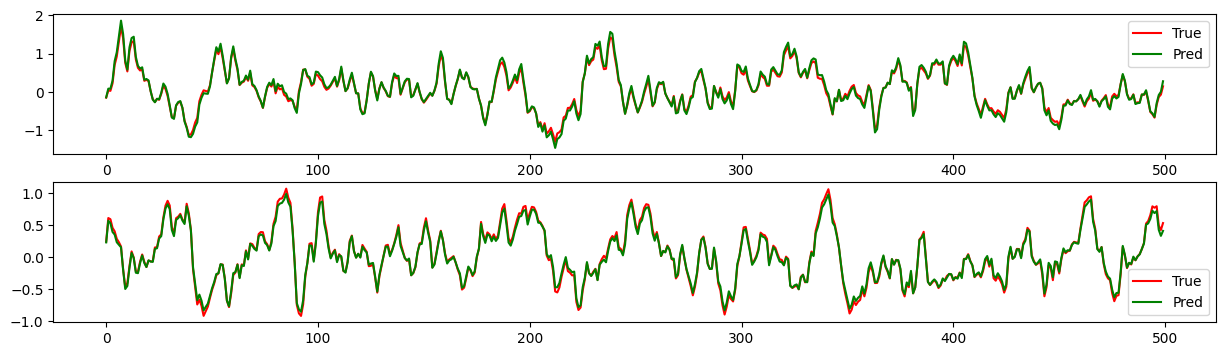

In [11]:
print(fitted_variational_params)
x_smoothed_kalman = p.smooth_seq(ys[0], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

### Streaming data

In [4]:
p_args.seq_length = 1_000_000 # keeping all previous settings except the sequence length

xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     num_seqs=1, 
                                     seq_length=p_args.seq_length,
                                     single_split_seq=False,
                                     load_from='')


elbo_mode = 'score,paris,bptt_depth_2'
trainer = SVITrainer(p=p,
                    theta_star=theta,
                    q=q,
                    optimizer='adam',
                    learning_rate=1e-3, 
                    optim_options='cst', # learning rate schedule
                    num_epochs=1, # number of full sweeps through the sequence
                    seq_length=p_args.seq_length,
                    num_samples=20, # number of monte carlo samples (or trajectories in the online case)
                    frozen_params='', # which parameters to hold fixed
                    num_seqs=p_args.num_seqs, 
                    training_mode=f'streaming,1,difference', # L_t - L_{t-1} / t
                    elbo_mode=elbo_mode,
                    logging_type='basic_logging')

key_init_params, key_montecarlo = jax.random.split(key, 2)
fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                key_montecarlo, 
                                data=(xs, ys), 
                                log_writer=None, 
                                args=None, 
                                log_writer_monitor=None)

NameError: name 'p_args' is not defined

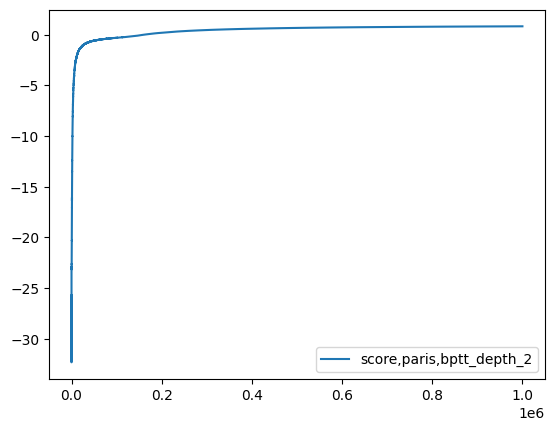

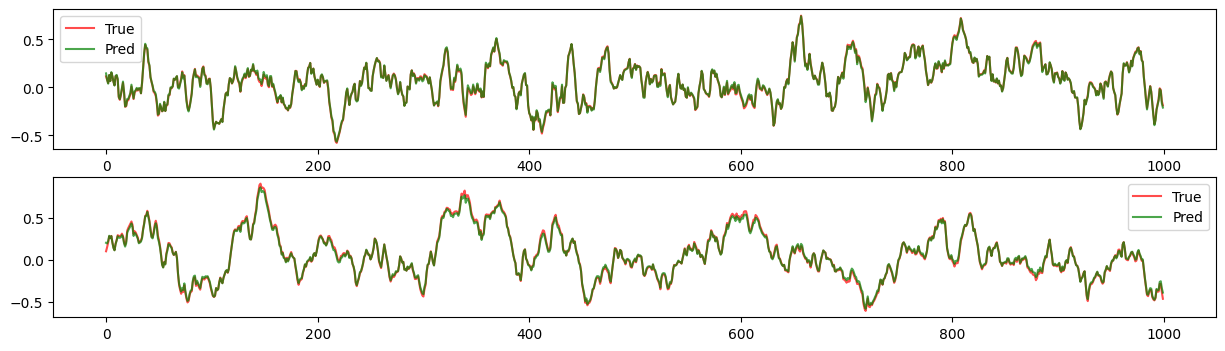

In [46]:
elbo_for_all_epochs = elbos.flatten()
plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()

x_smoothed_kalman = p.smooth_seq(ys[0][:1000], theta)[0]
x_smoothed_variational = q.smooth_seq(ys[0][:1000], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_smoothed_kalman, x_smoothed_variational)

## Chaotic RNN

### Setting up model and data

In [7]:
p_args = argparse.Namespace()

p_args.state_dim, p_args.obs_dim = 5,5
p_args.model = 'chaotic_rnn' 
p_args.seq_length = 500
p_args.loaded_seq = True
p_args.load_from = 'data/crnn/2022-10-18_15-28-00_Train_run'
p_args.range_transition_map_params = [0.8,1] # range of the components of the transition matrix
p_args.transition_matrix_conditionning = 'init_scale_by_dim' # constraint
p_args.default_transition_matrix = os.path.join(p_args.load_from, 'W.npy')

p_args.gamma = 2.5 # gamma for the chaotic rnn
p_args.tau = 0.025 # tau for the chaotic rnn
p_args.grid_size = 0.001 # discretization parameter for the chaotic rnn

p_args.emission_matrix_conditionning = 'diagonal'
p_args.range_emission_map_params = [-1,1]
p_args.default_emission_df = 2 # degrees of freedom for the emission noise
p_args.default_emission_matrix = 1.0 # diagonal values for the emission matrix
p_args.transition_bias = False 
p_args.emission_bias = False
p_args.num_seqs = 1 #

p_args.default_prior_mean = 0.0 # default value for the mean of Gaussian prior
p_args.default_prior_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the prior
p_args.default_transition_base_scale = 0.1 # default value for the diagonal components of the covariance matrix of the transition kernel
p_args.default_transition_bias = 0.0
p_args.default_emission_base_scale = 0.1
p_args.num_particles, p_args.num_smooth_particles = None, None

key = jax.random.PRNGKey(0)
key, key_params, key_sequences = jax.random.split(key, 3)
p, theta = get_generative_model(p_args, key_params)
xs, ys = p.sample_multiple_sequences(key_sequences, 
                                     theta, 
                                     1, 
                                     p_args.seq_length,
                                     single_split_seq=False)


### Setting up variational model

### Side-by-side comparison with Campbell et al.

In [5]:
q_args = argparse.Namespace()
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim 
q_args.model = 'nonamortized'
q_args.backwd_layers = (10,)

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

for elbo_mode in ['score,truncated,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-4, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=2, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,10', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')

    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos, aux_results = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=q_args, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()


Num params: 130
USING SCORE ELBO.
Using truncated gradients.


TypeError: true_fun and false_fun output must have identical types, got
({'base_s': {'_mean': 'ShapedArray(float32[5])', '_scale': {'_cov_chol': 'ShapedArray(float32[5])', '_cov': 'ShapedArray(float32[5])'}}, 'grad_H_bar': NonAmortizedBackwardSmoother.Params(backwd={'mlp/~/linear_0': {'b': 'ShapedArray(float32[2,10])', 'w': 'ShapedArray(float32[2,5,10])'}, 'mlp/~/linear_1': {'b': 'ShapedArray(float32[2,5])', 'w': 'ShapedArray(float32[2,10,5])'}, '~': {'backwd_sigma_diag': 'ShapedArray(float32[2,5])'}}, filt={'_mean': 'ShapedArray(float32[2,5])', '_scale': {'cov_chol': 'ShapedArray(float32[2,5])'}}), 'grad_log_q_bar': NonAmortizedBackwardSmoother.Params(backwd={'mlp/~/linear_0': {'b': 'ShapedArray(float32[2,10])', 'w': 'ShapedArray(float32[2,5,10])'}, 'mlp/~/linear_1': {'b': 'ShapedArray(float32[2,5])', 'w': 'ShapedArray(float32[2,10,5])'}, '~': {'backwd_sigma_diag': 'ShapedArray(float32[2,5])'}}, filt={'_mean': 'ShapedArray(float32[2,5])', '_scale': {'cov_chol': 'ShapedArray(float32[2,5])'}}), 'log_q': 'ShapedArray(float32[2])', 'stats': {'H': 'ShapedArray(float32[2])'}, 'x': 'ShapedArray(float32[2,5])'}, ({'_mean': 'ShapedArray(float32[5])', '_scale': {'_cov_chol': 'ShapedArray(float32[5])', '_cov': 'ShapedArray(float32[5])'}}, ({'mlp/~/linear_0': {'b': 'ShapedArray(float32[10])', 'w': 'ShapedArray(float32[5,10])'}, 'mlp/~/linear_1': {'b': 'ShapedArray(float32[5])', 'w': 'ShapedArray(float32[10,5])'}, '~': {'backwd_sigma_diag': 'ShapedArray(float32[5])'}}, ({'_mean': 'ShapedArray(float32[5])', '_scale': {'_cov': 'DIFFERENT ShapedArray(float32[5,5]) vs. ShapedArray(float32[5])', '_cov_chol': 'DIFFERENT ShapedArray(float32[5,5]) vs. ShapedArray(float32[5])'}}, {'_mean': 'ShapedArray(float32[5])', '_scale': {'_cov_chol': 'ShapedArray(float32[5])', '_cov': 'ShapedArray(float32[5])'}})))).

### Learning on streaming data

In [3]:
key = jax.random.PRNGKey(1)
q_args = argparse.Namespace()
q_args.model = 'johnson_backward,200'
q_args.state_dim, q_args.obs_dim = p_args.state_dim, p_args.obs_dim
q_args.transition_bias = False
q_args.emission_bias = False
layers = [int(nb) for nb in q_args.model.split(',')[-1].split('_')]
q_args.update_layers = (*layers,)
q_args.backwd_layers = 0
q_args.transition_matrix_conditionning = 'diagonal'
q_args.range_transition_map_params = (0.8, 1)
q_args.anisotropic = False

q_args = set_defaults(q_args)

q = get_variational_model(q_args)

for elbo_mode in ['score,paris,bptt_depth_2']:
    trainer = SVITrainer(p=p,
                        theta_star=theta,
                        q=q,
                        optimizer='adam',
                        learning_rate=1e-4, 
                        optim_options='cst', # learning rate schedule
                        num_epochs=1, # number of full sweeps through the sequence
                        seq_length=p_args.seq_length,
                        num_samples=100, # number of monte carlo samples (or trajectories in the offline case)
                        frozen_params='', # which parameters to hold fixed
                        num_seqs=p_args.num_seqs, 
                        training_mode='streaming,1,difference', 
                        elbo_mode=elbo_mode,
                        logging_type='basic_logging')


    key_init_params, key_montecarlo = jax.random.split(key, 2)
    fitted_variational_params, elbos = trainer.fit(key_init_params, 
                                    key_montecarlo, 
                                    data=(xs, ys), 
                                    log_writer=None, 
                                    args=q_args, 
                                    log_writer_monitor=None)

    elbo_for_all_epochs = elbos.flatten()
    plt.plot(elbo_for_all_epochs, label=elbo_mode)
plt.legend()


NameError: name 'q' is not defined

In [4]:
x_true = xs[0][:1000]
x_smoothed = q.smooth_seq(ys[0][:1000], fitted_variational_params)[0]
plot_x_true_against_x_pred(x_true=x_true, 
                           x_pred=x_smoothed)

NameError: name 'q' is not defined

### Langevin

Running for 10,000 iterations: 100%|██████████| 10000/10000 [00:03<00:00, 3096.08it/s]


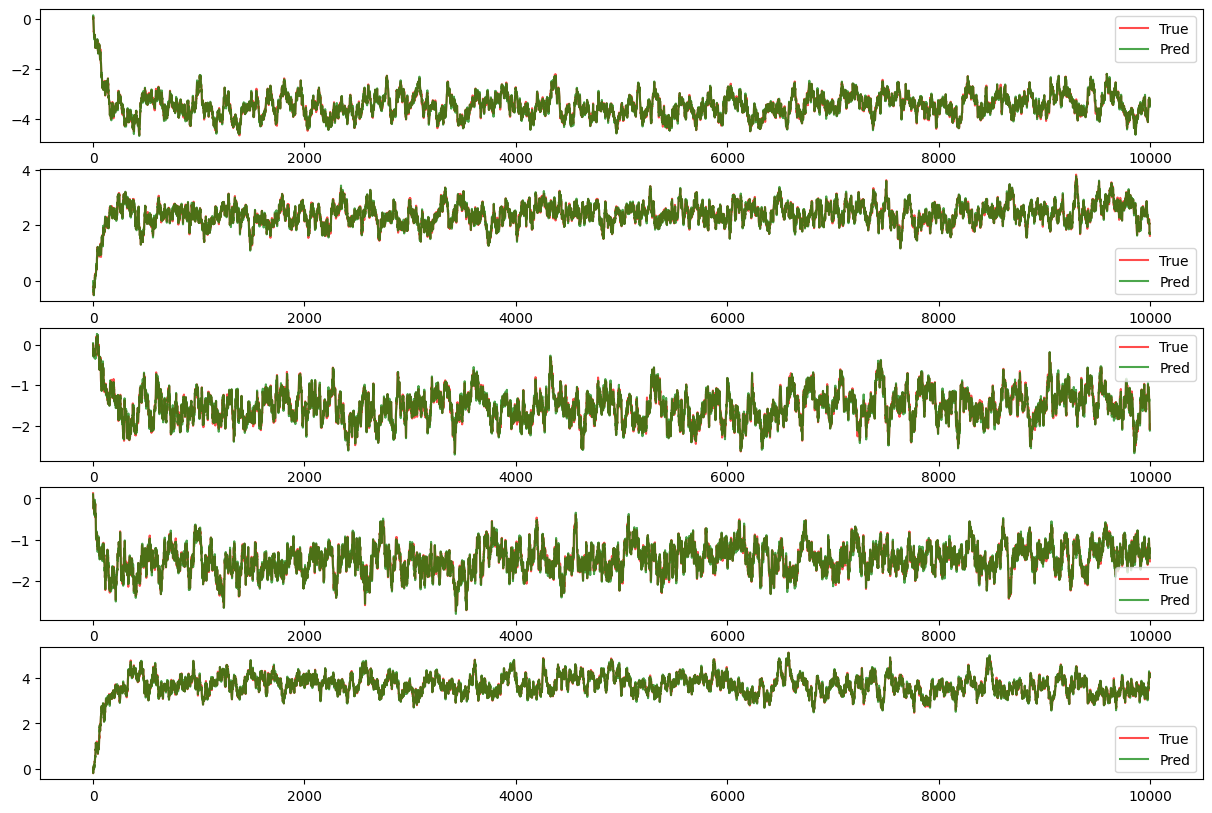

In [17]:
ula = ULA(p,
          num_steps=2*p_args.seq_length,
          h = 1e-3,
          num_particles=10)

x_pred = ula.filt(key, ys[0], theta)
plot_x_true_against_x_pred(xs[0], x_pred, y=None, save=True)
